In [3]:
%matplotlib inline

# Transfer Learning
In this assignment, we will use the weights of a network pre-trained in a particular problem as starting point to train our CNN to a different problem. As training a network from scratch is time-consuming and demands a lot of data, this is a frequent strategy, specially if both datasets (the one used for pre-training and the target) shares similar structures/elements/concepts. 

This is specially true when working with images. Most filters learned in initial convolutional layers will detect low-level elements, such as borders, corners and color blobs, which are common to most problems in the image domain. 

In this notebook, we will load the SqueezeNet architecture trained in the ImageNet dataset and fine-tune it to CIFAR-10.

## Imports

In [7]:
import os
import numpy as np
from random import sample, seed
seed(42)
np.random.seed(42)

import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = (15,15) # Make the figures a bit bigger

# Keras imports
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras import regularizers
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.preprocessing.image import load_img, img_to_array
from keras.datasets import cifar10
from keras.callbacks import TensorBoard
from sklearn.cross_validation import StratifiedShuffleSplit

EPOCHS = 10
LEARNING_RATE = 0.0001

#Utility to plot
def plotImages(imgList):
    for i in range(len(imgList)):
        plotImage(imgList[i])
        
        
def plotImage(img):
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot(111)

    ax.imshow(np.uint8(img), interpolation='nearest')
    plt.show()

## SqueezeNet definition
These methods define our architecture and load the weights obtained using ImageNet data.

In [8]:
# Fire Module Definition
sq1x1 = "squeeze1x1"
exp1x1 = "expand1x1"
exp3x3 = "expand3x3"
relu = "relu_"

def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '/'

    channel_axis = 3
    
    x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = Activation('relu', name=s_id + relu + sq1x1)(x)

    left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = Activation('relu', name=s_id + relu + exp1x1)(left)

    right = Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = Activation('relu', name=s_id + relu + exp3x3)(right)

    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x

#SqueezeNet model definition
def SqueezeNet(input_shape):
    img_input = Input(shape=input_shape) #placeholder
    
    x = Convolution2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(img_input)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)
    
    x = Dropout(0.5, name='drop9')(x)

    x = Convolution2D(1000, (1, 1), padding='valid', name='conv10')(x)
    x = Activation('relu', name='relu_conv10')(x)
    x = GlobalAveragePooling2D()(x)
    x = Activation('softmax', name='loss')(x)

    model = Model(img_input, x, name='squeezenet')

    # Download and load ImageNet weights
    model.load_weights('./squeezenet_weights_tf_dim_ordering_tf_kernels.h5')
    
    return model    

## CIFAR-10

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. The class are **airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck**.

Train/Val data. X:  (50000, 32, 32, 3) , Y:  (50000, 1)
Test data. X:  (10000, 32, 32, 3) , Y:  (10000, 1)

Class: frog


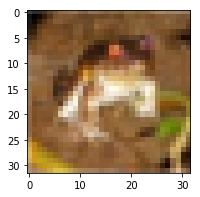

In [9]:
# Load data
(trainVal_data, trainVal_label), (X_test, y_test) = cifar10.load_data()
print("Train/Val data. X: ", trainVal_data.shape, ", Y: ", trainVal_label.shape)
print("Test data. X: ", X_test.shape, ", Y: ", y_test.shape)
print()

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

print('Class:', classes[trainVal_label.item(0)])
plotImage(trainVal_data[0])

# Prepare the data

# Separate trainVal in train (40000 labels) and val (10000 labels)
train_data = trainVal_data[:-10000]
train_label = trainVal_label[:-10000]
val_data = trainVal_data[-10000:]
val_label = trainVal_label[-10000:]
#print(train_data.shape, train_label.shape, val_data.shape, val_label.shape)

# Conform label arrays with the 10 classes of cifar-10
train_label = np_utils.to_categorical(train_label, 10)
val_label = np_utils.to_categorical(val_label, 10)
y_test = np_utils.to_categorical(y_test, 10)

-----------------
## SqueezeNet with frozen layers
Our initial attempt will be to remove SqueezeNet's top layers --- responsible for the classification into ImageNet classes --- and train a new set of layers to our CIFAR-10 classes. We will also freeze the layers before `drop9`. Our architecture will be like this:

<img src="frozenSqueezeNet.png" width=70% height=70%>

In [10]:
squeezeNetModel = SqueezeNet((32,32,3))

# Freeze layers
for layer in squeezeNetModel.layers:
    layer.trainable = False

# Add new classification layers
x = squeezeNetModel.layers[-5].output
x = Convolution2D(10, (1, 1), padding='valid', name='conv10')(x)
x = Activation('relu', name='relu_conv10')(x)
x = GlobalAveragePooling2D()(x)
x = Activation('softmax', name='loss')(x)

# New Model
model1 = Model(squeezeNetModel.inputs, x, name='squeezenet_new')
model1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 15, 15, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 15, 15, 64)   0           conv1[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 7, 7, 64)     0           relu_conv1[0][0]                 
__________________________________________________________________________________________________
fire2/sque

Now, we compile our model and train it:

In [11]:
# Compile model and train it
model1.compile(optimizer=Adam(lr=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])

model1.fit(x=train_data, y=train_label, epochs=EPOCHS, verbose=1)

Epoch 1/10
40000/40000 [==============================] - 16s 411us/step - loss: 6.5247 - acc: 0.1216
Epoch 2/10
40000/40000 [==============================] - 15s 367us/step - loss: 2.6025 - acc: 0.1196
Epoch 3/10
40000/40000 [==============================] - 17s 417us/step - loss: 2.3476 - acc: 0.1120
Epoch 4/10
40000/40000 [==============================] - 18s 445us/step - loss: 2.3142 - acc: 0.1125
Epoch 5/10
40000/40000 [==============================] - 17s 427us/step - loss: 2.3012 - acc: 0.1132
Epoch 6/10
40000/40000 [==============================] - 17s 418us/step - loss: 2.2953 - acc: 0.1134
Epoch 7/10
40000/40000 [==============================] - 17s 418us/step - loss: 2.2943 - acc: 0.1178
Epoch 8/10
40000/40000 [==============================] - 18s 460us/step - loss: 2.2864 - acc: 0.1225
Epoch 9/10
40000/40000 [==============================] - 21s 532us/step - loss: 2.2806 - acc: 0.1308
Epoch 10/10
40000/40000 [==============================] - 17s 428us/step - loss: 

Finally, let's evaluate on our test set:

In [12]:
# Evaluate on validation
score1 = model1.evaluate(x=val_data, y=val_label, verbose=1)

print('Validation loss:', score1[0])
print('Validation accuracy (NORMALIZED):', score1[1])

10000/10000 [==============================] - 4s 405us/step
Validation loss: 2.269451414108276
Validation accuracy (NORMALIZED): 0.1312


-----------
-----------
-----------
# Training last 2 Fire Modules + classification layers
As we could see, the frozen network performed very poorly. By freezing most layers, we do not allow SqueezeNet to adapt its weights to features present in CIFAR-10.

Let's try to unfreeze the last two fire modules and train once more. The architecture will be:
<img src="partFrozenSqueezeNet.png" width=70% height=70%>

In [13]:
squeezeNetModel = SqueezeNet((32,32,3))

#print([layer.name for layer in squeezeNetModel.layers])

# Freeze the mentioned layers
# Fire8 starts at position 48
for layer in squeezeNetModel.layers[:48]:
    layer.trainable = False

# Add new classification layers
x = squeezeNetModel.layers[-5].output
x = Convolution2D(10, (1, 1), padding='valid', name='conv10')(x)
x = Activation('relu', name='relu_conv10')(x)
x = GlobalAveragePooling2D()(x)
x = Activation('softmax', name='loss')(x)

# New Model
model2 = Model(squeezeNetModel.inputs, x, name='squeezenet_new')
model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 15, 15, 64)   1792        input_2[0][0]                    
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 15, 15, 64)   0           conv1[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 7, 7, 64)     0           relu_conv1[0][0]                 
__________________________________________________________________________________________________
fire2/sque

Now, we compile our model and train it:

In [14]:
# Compile model and train it
model2.compile(optimizer=Adam(lr=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])

model2.fit(x=train_data, y=train_label, epochs=EPOCHS, verbose=1)

Epoch 1/10
40000/40000 [==============================] - 35s 866us/step - loss: 2.3726 - acc: 0.1605
Epoch 2/10
40000/40000 [==============================] - 27s 677us/step - loss: 2.0293 - acc: 0.2557
Epoch 3/10
40000/40000 [==============================] - 44s 1ms/step - loss: 1.9286 - acc: 0.3005
Epoch 4/10
40000/40000 [==============================] - 39s 983us/step - loss: 1.8702 - acc: 0.3239
Epoch 5/10
40000/40000 [==============================] - 28s 709us/step - loss: 1.8128 - acc: 0.3411
Epoch 6/10
40000/40000 [==============================] - 28s 697us/step - loss: 1.7740 - acc: 0.3582
Epoch 7/10
40000/40000 [==============================] - 35s 880us/step - loss: 1.7341 - acc: 0.3798
Epoch 8/10
40000/40000 [==============================] - 30s 756us/step - loss: 1.6911 - acc: 0.3978
Epoch 9/10
40000/40000 [==============================] - 30s 754us/step - loss: 1.6609 - acc: 0.4130
Epoch 10/10
40000/40000 [==============================] - 30s 748us/step - loss: 1.

Finally, let's evaluate on our test set:

In [15]:
# Evaluate on validation
score2 = model2.evaluate(x=val_data, y=val_label, verbose=1)

print('Validation loss:', score2[0])
print('Validation accuracy (NORMALIZED):', score2[1])

10000/10000 [==============================] - 4s 354us/step
Validation loss: 1.5033092697143555
Validation accuracy (NORMALIZED): 0.4735


-----------
-----------
-----------
# Tensorboard

Tensorboard is a visualization tool for Tensorflow. Among other things, it allows us to monitor the progress of our training, plot metrics per epochs, visualize the architecture's schematics. 

Just like for Early Stopping, we will use the [Tensorboard callback](https://keras.io/callbacks/#tensorboard) to log the information about our training. An example of usage, would be:

As your training progresses, Keras will log the metrics (e.g., loss, accuracy) to `<<LOG_DIR>>` (**make sure `<<LOG_DIR>>` is a valid directory)**. On your terminal, you will need to run Tensorboard, assign a port and access it via browser (just like jupyter).

#### ----> MAKE SURE YOU USE A DIFFERENT PORT FOR JUPYTER AND TENSORBOARD <----

### Docker
For those using docker, open a new terminal and create a new container (using the same image) running Tensorboard:

For example:

After starting Tensorboard, access it via browser on `http://localhost:<<port_container>>`.

### Anaconda
$ tensorboard --logdir=<<LOG_DIR>> --port=<<port>>

After starting Tensorboard, access it via browser on `http://localhost:<<port>>`.

-----------
-----------
-----------

# Fine-tuning all layers

What if we fine-tune all layers of SqueezeNet?
<img src="unfrozenSqueezeNet.png" width=70% height=70%>

In [16]:
squeezeNetModel = SqueezeNet((32,32,3))

for layer in squeezeNetModel.layers:
    layer.trainable = True       #by default they are all trainable, but just for clarification

# Add new classification layers
x = squeezeNetModel.layers[-5].output
x = Convolution2D(10, (1, 1), padding='valid', name='conv10')(x)
x = Activation('relu', name='relu_conv10')(x)
x = GlobalAveragePooling2D()(x)
x = Activation('softmax', name='loss')(x)

# New Model
model3 = Model(squeezeNetModel.inputs, x, name='squeezenet_new')

Now, we compile our model and train it:

In [ ]:
from time import time

# Compile model
model3.compile(optimizer=Adam(lr=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])

# Tensorboard callback
#tbCallBack = TensorBoard(log_dir="./logs/rafa", write_graph=True)
tbCallBack = TensorBoard(log_dir="/home/julianny-favinha/tensorboard-logs".format(time()), write_graph=True)

# Train model
model3.fit(x=train_data, y=train_label, epochs=EPOCHS, verbose=1, callbacks=[tbCallBack])

Epoch 1/10
40000/40000 [==============================] - 76s 2ms/step - loss: 2.0818 - acc: 0.2579
Epoch 2/10
40000/40000 [==============================] - 84s 2ms/step - loss: 1.5394 - acc: 0.4573
Epoch 3/10
40000/40000 [==============================] - 64s 2ms/step - loss: 1.2918 - acc: 0.5636
Epoch 4/10
40000/40000 [==============================] - 69s 2ms/step - loss: 1.1463 - acc: 0.6208
Epoch 5/10
40000/40000 [==============================] - 72s 2ms/step - loss: 1.0380 - acc: 0.6622
Epoch 6/10
40000/40000 [==============================] - 69s 2ms/step - loss: 0.9497 - acc: 0.6926
Epoch 7/10
40000/40000 [==============================] - 68s 2ms/step - loss: 0.8848 - acc: 0.7151
Epoch 8/10
40000/40000 [==============================] - 68s 2ms/step - loss: 0.8236 - acc: 0.7328
Epoch 9/10
40000/40000 [==============================] - 70s 2ms/step - loss: 0.7714 - acc: 0.7497
Epoch 10/10
22176/40000 [===============>..............] - ETA: 31s - loss: 0.7250 - acc: 0.7618

Finally, let's evaluate on our validation set:

In [ ]:
# Evaluate on validation
score3 = model3.evaluate(x=val_data, y=val_label, verbose=1)

print('Validation loss:', score3[0])
print('Validation accuracy (NORMALIZED):', score3[1])

In [ ]:
# Evaluate your best model on test
models = [model1, model2, model3]
models_names = ['SqueezeNet with frozen layers', 
                'Training last 2 Fire Modules + classification layers', 
                'Fine-tuning all layers']

accuracies = [score1[1], score2[1], score3[1]]
print('Models accuracies:', accuracies)

max_index = accuracies.index(max(accuracies))
print('Best model:', models_names[max_index])

best_score = models[max_index].evaluate(x=X_test, y=y_test, verbose=1)
print('Validation loss:', best_score[0])
print('Validation accuracy (NORMALIZED):', best_score[1])

## Saving the model
Now that we are working on more complex tasks and our trainings are starting to take more time it is usually a good idea to save the trained model from time to time. [Keras has a lot of ways of saving and loading the model](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model), but in this exercise we will use the simplest of them all: `model.save()`. It saves the architecture, the weights, the choice of loss function/optimizer/metrics and even the current state of the training, so you can resume your training later.

In [ ]:
model1.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'

## Loading a model
Once we have our model trained, we can load it using:

In [ ]:
from keras.models import load_model

del model1  # Will delete model, only to check if load_model is working

# returns a compiled model identical to the previous one
model = load_model('my_model.h5')

# evaluate test set again... should give us the same result
score = model.evaluate(x=X_test, y=y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy (NORMALIZED):', score[1])